In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline
import tensorflow as tf
import seaborn as sns
import matplotlib.style as style
from tensorflow.keras import datasets, layers, models

2025-05-11 11:31:57.550711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746963117.740168      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746963117.804781      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#!echo "Y" |!pip uninstall tensorflow
#!pip uninstall seaborn
#!pip install tensorflow
#!pip install seaborn
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [3]:
## Data Exploration

#### We will start by loading the CSV files in order to explore the data a bit.

In [4]:
# !find /kaggle/input/clefmed2025-concept-detection/ -name 'cui_names.csv'
data_filename = '/kaggle/input/clefmed2025-concept-detection/cui_names.csv'
string_concepts = pd.read_csv(data_filename,header = None)

In [5]:
string_concepts.columns = ['CUIs','Canonical']

In [6]:
string_concepts['Canonical']= string_concepts['Canonical'].str.split(',')

In [7]:
string_concepts.shape

(2481, 2)

In [8]:
string_concepts.head()

,CUIs,Canonical
0,CUI,[Name]
1,C0224519,"[Synchondrosis, NOS]"
2,C0018790,[heart; stoppage]
3,C0002949,[dissection of artery]
4,C0152013,[LUNG CANCER ADENOCARCINOMA]


In [9]:
data_filename = '/kaggle/input/clefmed2025-concept-detection/train_concepts.csv'
train_concepts = pd.read_csv(data_filename)

In [10]:
train_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_train_0,C0040405
1,ImageCLEFmedical_Caption_2025_train_1,C1306645;C0817096;C0442800;C0018787;C0242073
2,ImageCLEFmedical_Caption_2025_train_2,C0040405;C0856747
3,ImageCLEFmedical_Caption_2025_train_3,C0041618
4,ImageCLEFmedical_Caption_2025_train_4,C0040405;C0040053


We are going to use a **copy** of the dataframe in order to calculate some staticstics

In [11]:
copy = train_concepts.copy()

* We will investigate which concept is more frequent on the images

In [12]:
copy['CUIs']= copy['CUIs'].str.split(';')

In [13]:
x = sum(copy.CUIs, [])
from collections import Counter
c = Counter(x)
results =c.most_common(10)

In [14]:
most_frequent = pd.DataFrame(results)

In [15]:
most_frequent.columns = ['CUIs','Images']
umls_terms = pd.merge(most_frequent, string_concepts,on = 
                     'CUIs', how = 'left') 

In [16]:
umls_terms

,CUIs,Images,Canonical
0,C0040405,27792,[CT]
1,C1306645,21992,[Radiograph]
2,C0024485,12666,[Magnetic resonance imaging - action]
3,C0041618,11425,[Ultrasound imaging - action]
4,C0817096,10233,[chest and upper back]
5,C0002978,4796,[X-ray of the blood vessel]
6,C0000726,4281,[Abdominopelvis]
7,C0037303,4110,[Set of bones of cranium]
8,C0030797,3662,"[Structure of pelvic region, unspecified]"
9,C0023216,3231,"[Structure of lower extremity, unspecified]"


* We notice that the most common CUIs are standard scanning procedures

* The next step would be to find out how many tags are there in each image.

In [17]:
copy['Number of Tags'] = copy.ID.str.len()

In [18]:
copy.head()

,ID,CUIs,Number of Tags
0,ImageCLEFmedical_Caption_2025_train_0,[C0040405],37
1,ImageCLEFmedical_Caption_2025_train_1,"[C1306645, C0817096, C0442800, C0018787, C0242...",37
2,ImageCLEFmedical_Caption_2025_train_2,"[C0040405, C0856747]",37
3,ImageCLEFmedical_Caption_2025_train_3,[C0041618],37
4,ImageCLEFmedical_Caption_2025_train_4,"[C0040405, C0040053]",37


In [19]:
data_filename = '/kaggle/input/clefmed2025-concept-detection/valid_concepts.csv'
val_concepts = pd.read_csv(data_filename)

In [20]:
val_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_valid_0,C0041618;C0027651
1,ImageCLEFmedical_Caption_2025_valid_1,C1306645;C0000726;C0017070
2,ImageCLEFmedical_Caption_2025_valid_2,C1306645;C0037949;C0017070
3,ImageCLEFmedical_Caption_2025_valid_3,C1306645;C0000726;C0183512
4,ImageCLEFmedical_Caption_2025_valid_4,C1306645;C0000726;C0016169


#### Let's now continue by ploting some images 

In [21]:
from PIL import Image

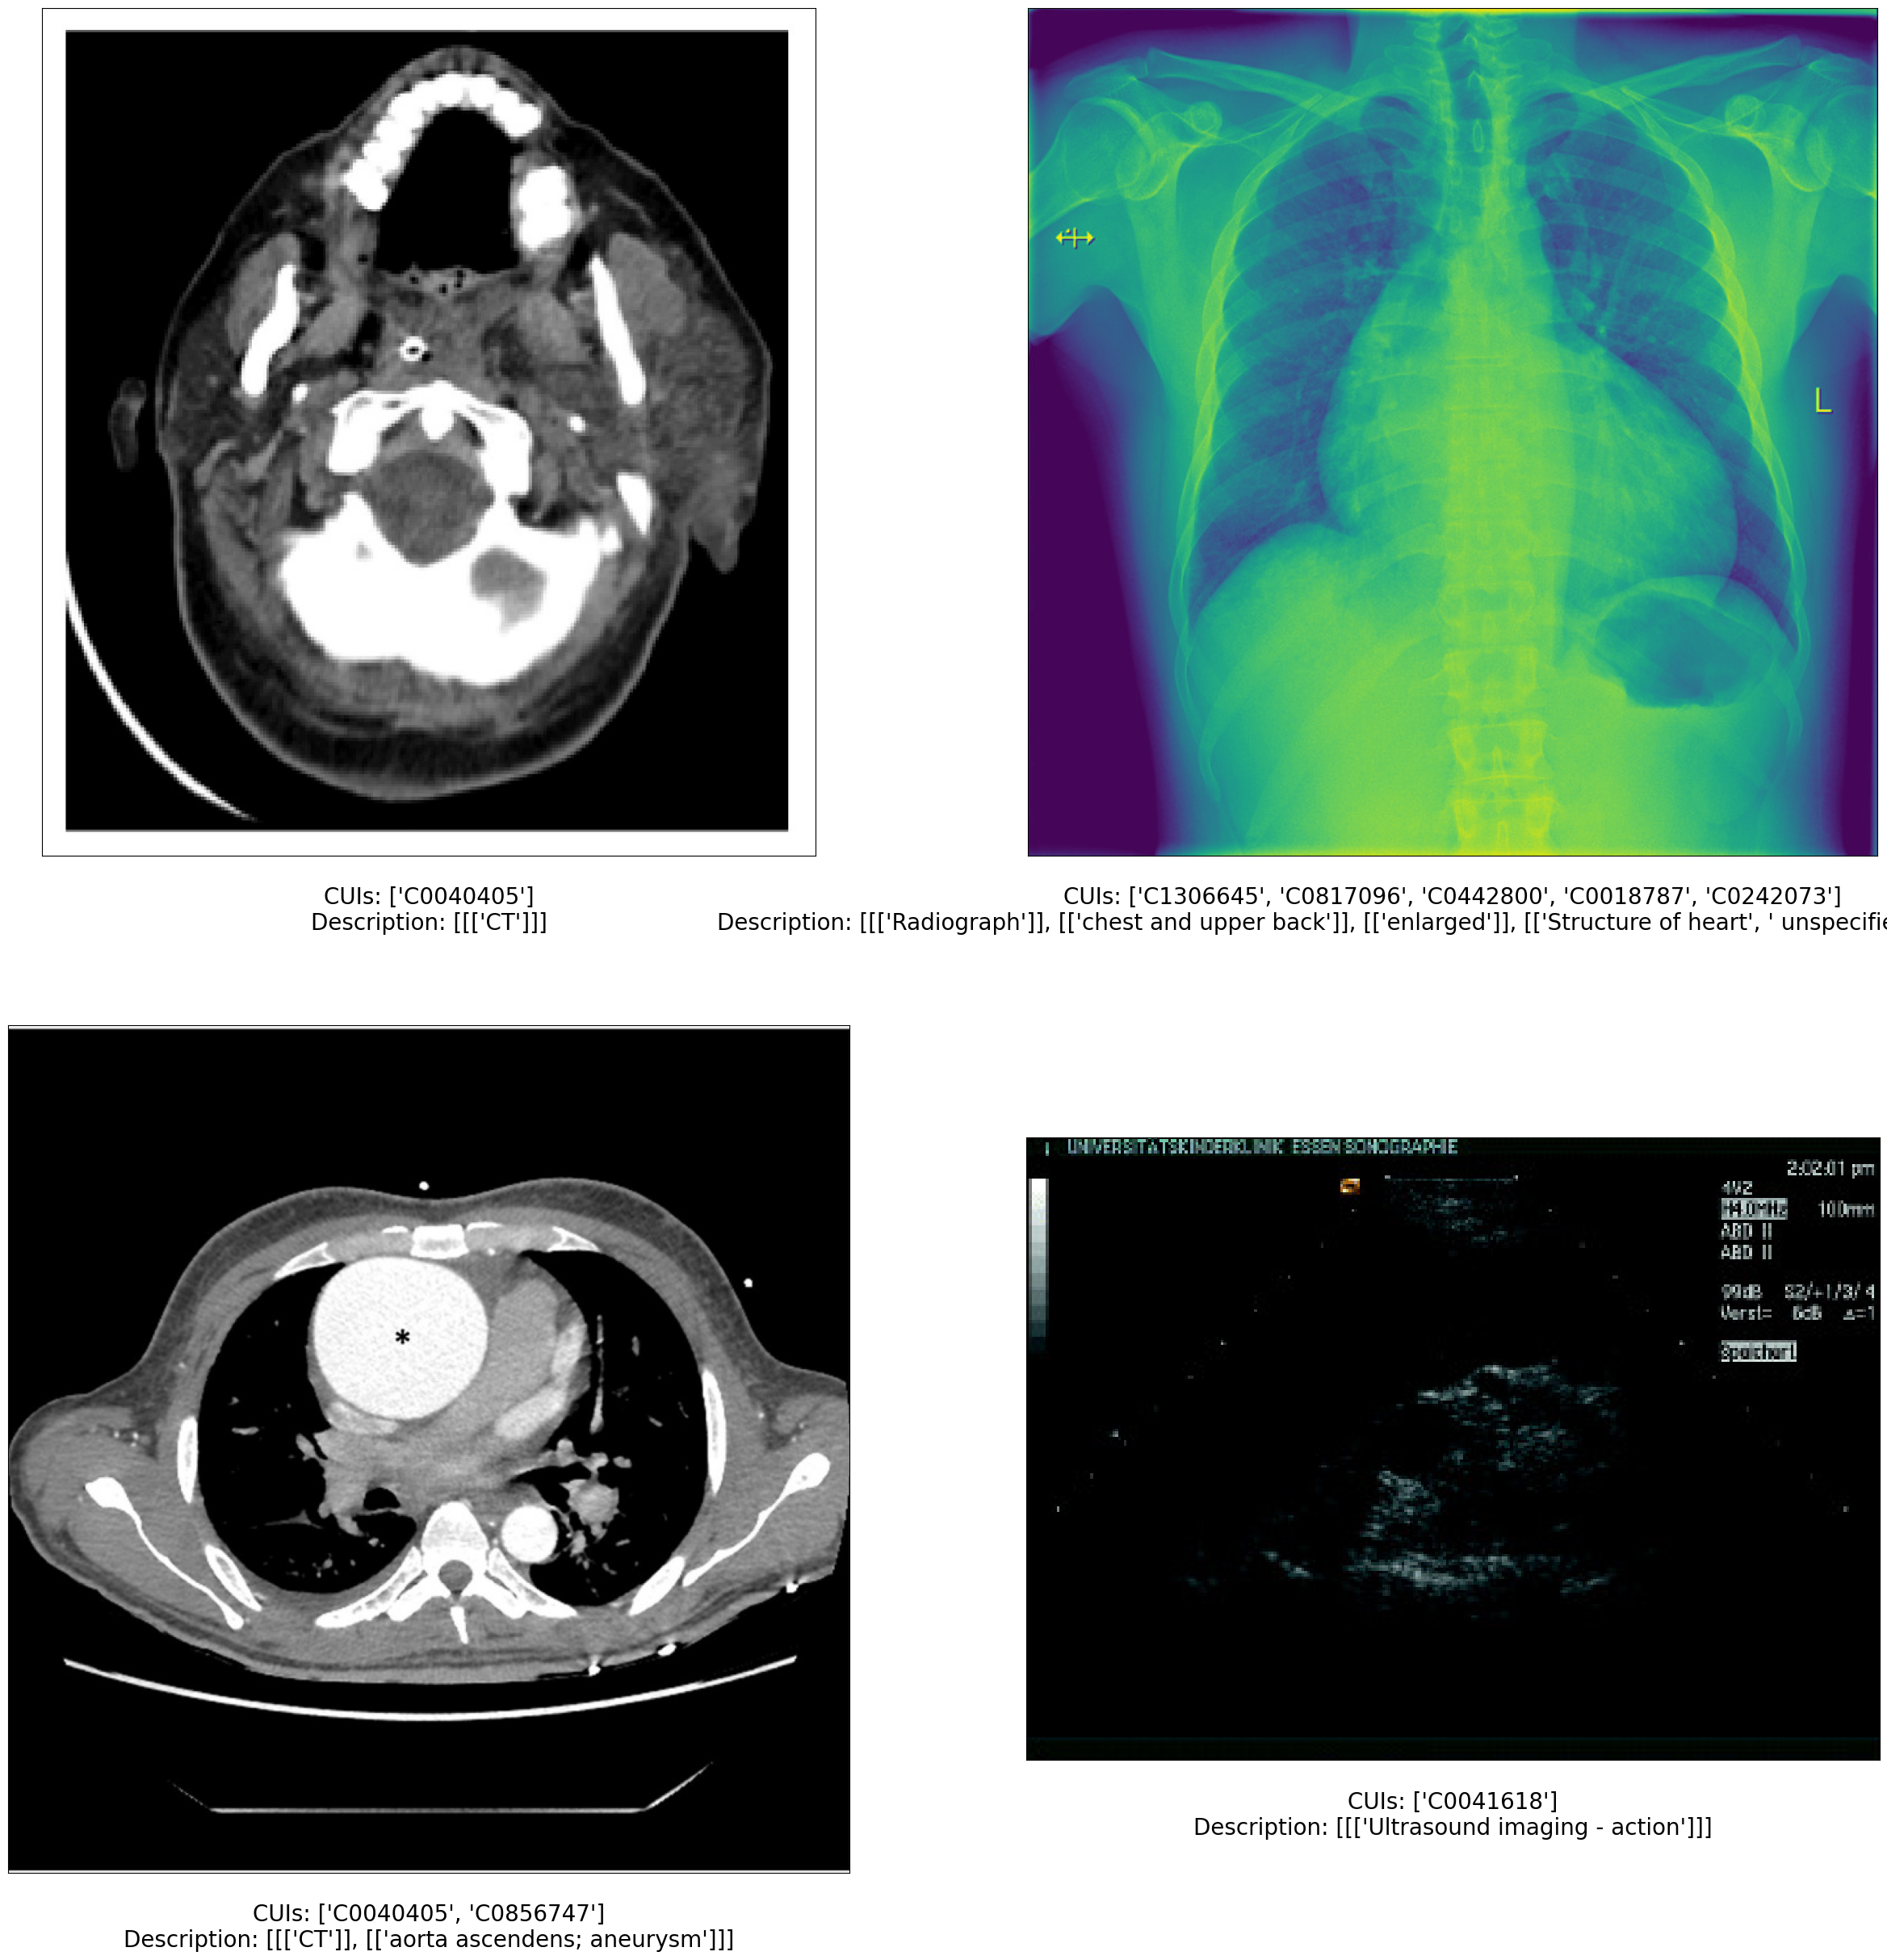

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

image_base_path = '/kaggle/input/clefmed2025-concept-detection/train/home/damm/clef/data/2025/splits/train/'

plt.figure(figsize=(30,30))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    image_path = image_base_path + copy.ID[i] + '.jpg'
    img = Image.open(image_path)
    plt.imshow(img)
    
    desc = []
    for item in copy.CUIs[i]:
        temp = string_concepts.loc[string_concepts['CUIs'] == item]
        desc.append(temp['Canonical'].tolist())
    
    plt.xlabel('\n' + 'CUIs: ' + str(copy.CUIs[i]) + '\nDescription: ' + str(desc), fontsize=20)

## Data Preprocessing

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### We need to transform the labels from the ';' delimeter to a list of strings

In [24]:
train_concepts['CUIs']= train_concepts['CUIs'].str.split(';')

#### We will also add the extension '.jpg' in order for the generator to be able to identify the files

In [25]:
train_concepts['ID'] = train_concepts['ID'] +'.jpg'

In [26]:
train_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_train_0.jpg,[C0040405]
1,ImageCLEFmedical_Caption_2025_train_1.jpg,"[C1306645, C0817096, C0442800, C0018787, C0242..."
2,ImageCLEFmedical_Caption_2025_train_2.jpg,"[C0040405, C0856747]"
3,ImageCLEFmedical_Caption_2025_train_3.jpg,[C0041618]
4,ImageCLEFmedical_Caption_2025_train_4.jpg,"[C0040405, C0040053]"


In [27]:
val_concepts['CUIs']= val_concepts['CUIs'].str.split(';')

In [28]:
val_concepts['ID']= val_concepts['ID']+'.jpg'

In [29]:
val_concepts.head()

,ID,CUIs
0,ImageCLEFmedical_Caption_2025_valid_0.jpg,"[C0041618, C0027651]"
1,ImageCLEFmedical_Caption_2025_valid_1.jpg,"[C1306645, C0000726, C0017070]"
2,ImageCLEFmedical_Caption_2025_valid_2.jpg,"[C1306645, C0037949, C0017070]"
3,ImageCLEFmedical_Caption_2025_valid_3.jpg,"[C1306645, C0000726, C0183512]"
4,ImageCLEFmedical_Caption_2025_valid_4.jpg,"[C1306645, C0000726, C0016169]"


## Data Generators

#### We will define the path for the images directories beforehand

In [30]:
import os

In [31]:
# train_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/train'
# validation_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/valid'
# test_dir = '/home/ex5/Desktop/ImageCLEF/dataset/images/test'

train_dir = '/kaggle/input/clefmed2025-concept-detection/train/home/damm/clef/data/2025/splits/train'
validation_dir = '/kaggle/input/clefmed2025-concept-detection/valid/home/damm/clef/data/2025/splits/valid'  # Only if it exists
test_dir = '/kaggle/input/clefmed2025-concept-detection/test/test'

In [32]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
num_test = len(os.listdir(test_dir))
total_train = num_tr
total_val = num_val

In [33]:
print('total training images:', num_tr)
print('total validation images:', num_val)
print('total testing images:', num_test)

total training images: 80091
total validation images: 17277
total testing images: 19267


* We will get 128 images per batch.

* We will train for 2 epochs.

* We will size the images to 224x224 pixels in order to also be compliable with Pre-trained models.

In [34]:
batch_size = 128
epochs = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

* We will read the batches using `ImageDataGenerator`, offerred by keras.

* This will create a Python generator that, when we call it, will return the next batch.

* While doing so, it will scale the pixel values from 0 to 1.

#### We will also augment the train images using random horizontal flip

In [35]:
train_image_generator = ImageDataGenerator(rescale=1./255,horizontal_flip = True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_image_generator=ImageDataGenerator(rescale=1./255.)# Generator for our testing data


In [36]:
dev_image_generator = ImageDataGenerator(rescale = 1./255.)#Generator for the valiation evaluation

#### We are going to create a column containg the index in order to apply multilabel encoding in the steps ahead 

In [37]:
train_concepts['index'] = train_concepts.index

In [38]:
val_concepts['index'] = val_concepts.index

#### We will combine the two dataframes in order for the classifier to be trained wth all classes names

In [39]:
full = pd.concat([train_concepts, val_concepts], sort=False)

In [40]:
full.shape

(97368, 3)

#### We will create the training and validation generators using the data from the dataframes and the corresponding images.

In [41]:
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=full.iloc[0:69999],#we only get the training images
                                                           directory = train_dir,
                                                           x_col="ID",
                                                           y_col="index",
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'other'
                                                          )

Found 69999 validated image filenames.


In [42]:
x, _ = next(train_data_gen)
print(x.shape)  # This should print (batch_size, 224, 224, 3)

(128, 224, 224, 3)


#### We are going to transform the labels to arrays using Scikit Learn MultiLabel Binarizer

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(full['CUIs'].values)

MultiLabelBinarizer()

In [44]:
N_LABELS = len(mlb.classes_)

In [45]:
list(mlb.classes_)

['C0000726',
 'C0000741',
 'C0000833',
 'C0000846',
 'C0000962',
 'C0001074',
 'C0001080',
 'C0001162',
 'C0001168',
 'C0001208',
 'C0001209',
 'C0001339',
 'C0001428',
 'C0001430',
 'C0001511',
 'C0001516',
 'C0001527',
 'C0001624',
 'C0001625',
 'C0001863',
 'C0002382',
 'C0002390',
 'C0002448',
 'C0002638',
 'C0002708',
 'C0002760',
 'C0002895',
 'C0002940',
 'C0002949',
 'C0002978',
 'C0003086',
 'C0003087',
 'C0003090',
 'C0003151',
 'C0003165',
 'C0003461',
 'C0003483',
 'C0003484',
 'C0003486',
 'C0003489',
 'C0003492',
 'C0003501',
 'C0003504',
 'C0003507',
 'C0003516',
 'C0003615',
 'C0003617',
 'C0003707',
 'C0003838',
 'C0003842',
 'C0003855',
 'C0003864',
 'C0003943',
 'C0003956',
 'C0003962',
 'C0003964',
 'C0004030',
 'C0004031',
 'C0004144',
 'C0004153',
 'C0004170',
 'C0004454',
 'C0004455',
 'C0004456',
 'C0004457',
 'C0004526',
 'C0004626',
 'C0004781',
 'C0004811',
 'C0005400',
 'C0005401',
 'C0005423',
 'C0005558',
 'C0005615',
 'C0005682',
 'C0005683',
 'C0005695',

In [46]:
N_LABELS

2479

#### We will use this helper function to transform the binarizer to each set

In [47]:
def multilabel_flow_from_dataframe(data_generator, mlb,df):
    for x, y in data_generator:
        indices = y.astype(int).tolist()
        y_multi = mlb.transform(
            df.iloc[indices]['CUIs'].values.tolist()
        )
        yield x, y_multi

In [48]:
multilabel_generator_train = multilabel_flow_from_dataframe(
    train_data_gen, mlb,train_concepts
)

* We are doing the same job for the validation images

In [49]:
# Filter only the validation subset
validation_df = full[full['ID'].str.contains('valid')].copy()

# Fix the ID column (only once!)
validation_df['ID'] = validation_df['ID'].str.extract(r'(ImageCLEFmedical_Caption_2025_valid_\d+)')[0] + '.jpg'

# Now check again
print(validation_df['ID'].head())

0    ImageCLEFmedical_Caption_2025_valid_0.jpg
1    ImageCLEFmedical_Caption_2025_valid_1.jpg
2    ImageCLEFmedical_Caption_2025_valid_2.jpg
3    ImageCLEFmedical_Caption_2025_valid_3.jpg
4    ImageCLEFmedical_Caption_2025_valid_4.jpg
Name: ID, dtype: object


In [50]:
val_data_gen = validation_image_generator.flow_from_dataframe(
    dataframe = validation_df,
    directory = validation_dir,
    x_col = "ID",
    y_col = "index",
    shuffle = False,
    batch_size = batch_size,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'other'
)

Found 17277 validated image filenames.


In [51]:
multilabel_generator_val = multilabel_flow_from_dataframe(
    val_data_gen,mlb,val_concepts
)

In [52]:
import os

# List all actual test images
test_dir = '/kaggle/input/clefmed2025-concept-detection/test/test'
test_files = os.listdir(test_dir)

# Convert to DataFrame
test_df = pd.DataFrame({'ID': test_files})

# If you need to add dummy labels (for example, to match y_col if class_mode is not None)
# test_df['dummy'] = 0

# Create the test data generator
test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='ID',
    shuffle=False,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None
)

Found 19267 validated image filenames.


* Last, we create a generator in order to use it for the validation images evaluation

In [53]:
dev_data_gen = dev_image_generator.flow_from_dataframe    (
                                                            dataframe=full,
                                                             directory=validation_dir,
                                                            x_col='ID',
                                                             shuffle = False,
                                                             batch_size=batch_size,
                                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode = None
)

Found 17277 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 80091 invalid image filename(s) in x_col="ID". These filename(s) will be ignored.
  warnings.warn(


### DenseNet

In [54]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers
import tensorflow as tf

# Use DenseNet121 as the base model
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='max'
)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1746963794.065548      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746963794.066244      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
# Define the number of output classes (match the label shape)
num_classes = 2479  # This must match the label shape

# Create the new model by adding a Dense layer for classification
model_new = tf.keras.Sequential([
    base_model,
    layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Display the model architecture
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2479)                │       2,540,975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,578,479 (36.54 MB)

 Trainable params: 2,540,975 (9.69 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [56]:
# Compile the model
model_new.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
# Fit the model with your data
history_2 = model_new.fit(
    multilabel_generator_train,
    steps_per_epoch=total_train // batch_size,
    epochs=15,
    validation_data=multilabel_generator_val,
    validation_steps=total_val // batch_size
)

Epoch 1/15


I0000 00:00:1746963818.568307     100 service.cc:148] XLA service 0x7f385848b4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746963818.568985     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746963818.568996     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746963821.240472     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746963839.443669     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 1053s 2s/step - accuracy: 0.2486 - loss: 0.0296 - val_accuracy: 0.3021 - val_loss: 0.0063
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - accuracy: 0.3070 - loss: 0.0058 - val_accuracy: 0.3014 - val_loss: 0.0060
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 618s 991ms/step - accuracy: 0.3090 - loss: 0.0054 - val_accuracy: 0.3137 - val_loss: 0.0059
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.3147 - loss: 0.0051 - val_accuracy: 0.2896 - val_loss: 0.0060
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.3118 - loss: 0.0050 - val_accuracy: 0.2960 - val_loss: 0.0060
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 581s 930ms/step - accuracy: 0.3170 - loss: 0.0048 - val_accuracy: 0.3011 - val_loss: 0.0061
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 509s 815ms/step - accuracy: 0.3143 - loss: 0.0046 - val_accuracy: 0.3021 - val_loss: 0.0062
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 553s 886ms/step - accuracy: 0.3150 - loss: 0.0044 - val_ac

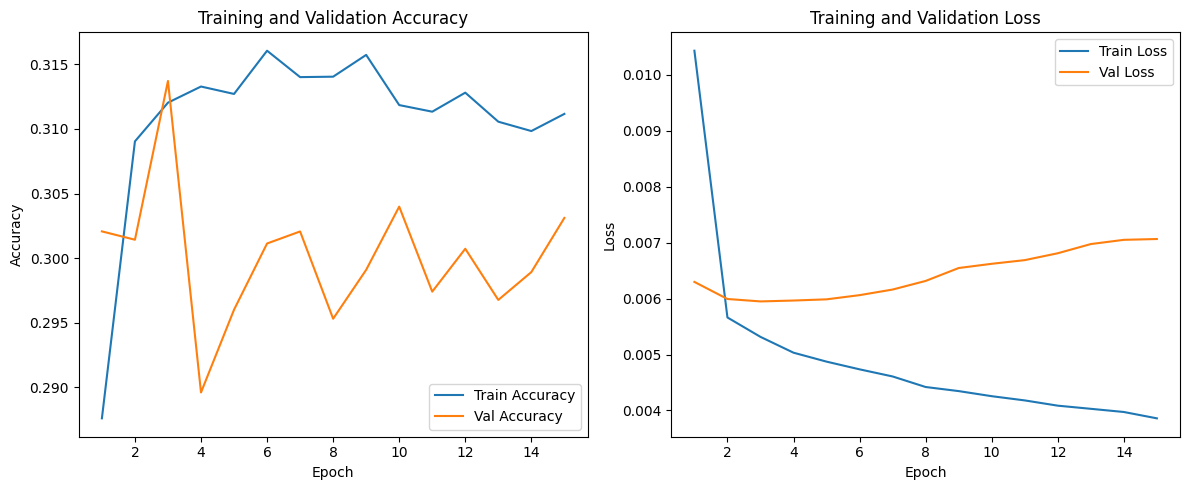

In [58]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [59]:
from IPython.display import FileLink
FileLink('/kaggle/working/ResNet50_Augmented_1944_epoch_50.h5')

/kaggle/working/ResNet50_Augmented_1944_epoch_50.h5

In [ ]:
model_new.save('/kaggle/working/my_model_dataset/ResNet50_Augmented_1944_epoch_50.h5')

In [ ]:
from IPython.display import FileLink
FileLink('/kaggle/working/my_model_dataset/ResNet50_Augmented_1944_epoch_50.h5')

In [ ]:
!pip install -q kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/kaggle/working"

In [63]:
# !mkdir -p /kaggle/working/my_model_dataset

In [ ]:
import shutil
shutil.move(
    "/kaggle/working/ResNet50_Augmented_1944_epoch_50.h5",
    "/kaggle/working/my_model_dataset/ResNet50_Augmented_1944_epoch_50.h5"
)

In [ ]:
metadata = {
    "title": "ResNet50 Augmented Model",
    "id": "your-kaggle-username/resnet50-augmented-model",
    "licenses": [{"name": "CC0-1.0"}]
}
import json
with open("/kaggle/working/my_model_dataset/dataset-metadata.json", "w") as f:
    json.dump(metadata, f)


In [ ]:
import os
os.makedirs('/kaggle/working/.kaggle', exist_ok=True)
import shutil
shutil.copy('/kaggle/input/kaggle/kaggle.json', '/kaggle/working/.kaggle/kaggle.json')
os.chmod('/kaggle/working/.kaggle/kaggle.json', 0o600)
os.environ['KAGGLE_CONFIG_DIR'] = '/kaggle/working/.kaggle'
!kaggle datasets list

In [ ]:
import json

# Load the existing metadata file
with open('/kaggle/working/my_model_dataset/dataset-metadata.json', 'r') as f:
    metadata = json.load(f)

# Edit the metadata, specifically the 'id' field
metadata['id'] = 'sadiqahmushtaq/resnet50-augmented-model'  # Replace with your Kaggle username and desired dataset name

# Save the updated metadata back to the file
with open('/kaggle/working/my_model_dataset/dataset-metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)


In [ ]:
!kaggle datasets create -p /kaggle/working/my_model_dataset


## Load models

In [ ]:
from tensorflow.keras.models import load_model
import keras

In [ ]:
 keras.backend.clear_session()

In [ ]:
#model_1 = load_model('UMLS Tags Augmented for 5528.h5')
#model_2 = load_model('MobileNetV2_Augmented_1944_epoch20.h5')
# model_3 = load_model('ResNet50_Augmented_1944_epoch15.h5')
#model_4 = load_model('UMLS Tags_3.h5')# Trained for 5216 classes
#model_5 = load_model('DenseNet121_epoch35.h5')
#model_6 = load_model('Chexnet_Model.h5')


from tensorflow.keras.models import load_model

# Load the model from the correct path
model_3 = load_model('/kaggle/working/my_model_dataset/ResNet50_Augmented_1944_epoch_15.h5')

print("Model loaded successfully!")

In [ ]:
# test_dir1 = '/home/ex5/Desktop/ImageCLEF/dataset/test_images'

test_dir1 = '/kaggle/input/clefmed2025-concept-detection/test/test'

In [ ]:
# test_image_generator1 = test_image_generator.flow_from_directory(
#     test_dir1,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=batch_size,
#     class_mode=None,  # Only data, no labels
#     shuffle=False  # Do not shuffle the data
# )
# print(batch_size)
# print(IMG_HEIGHT, IMG_WIDTH)
# print(test_dir1)

import pandas as pd
import os

# Create a dataframe listing all image files
test_image_filenames = os.listdir(test_dir1)
test_df = pd.DataFrame(test_image_filenames, columns=['filename'])

test_image_generator1 = test_image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir1,
    x_col='filename',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

## Predictions

##### Validation Data

In [ ]:
predictions_3 = model_3.predict(test_image_generator1)

## Output

#### We used the following procedure for all of the above models

In [ ]:
val_predictions = predictions_3

In [ ]:
val_predictions.shape

In [ ]:
def split_to_semicolons(values):
    items = ''
    for item in values:
        items = item +';' +items
    items = items.rstrip(';')    
    return items  

In [ ]:
def to_output_file(val_predictions, threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = [mlb.classes_[value] for value in temp]
        labels.append(label)
    
    # Updated valid image directory path
    valid_image_dir = '/kaggle/input/clefmed2025-concept-detection/valid/home/damm/clef/data/2025/splits/valid'
    
    files = pd.DataFrame([])
    files = files._append(os.listdir(valid_image_dir))
    files.columns = ['image']
    files = files.apply(lambda S: S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x: split_to_semicolons(x))
    
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.CUIs
    return candidate

In [ ]:
def to_output_file_test(val_predictions, threshold):
    labels = []
    for i in range(val_predictions.shape[0]):
        temp = np.where(val_predictions[i] > threshold)[0]
        label = [mlb.classes_[value] for value in temp]
        labels.append(label)

    # Updated test image directory path
    test_image_dir = '/kaggle/input/clefmed2025-concept-detection/test/test'
    
    files = pd.DataFrame([])
    files = files._append(os.listdir(test_image_dir))
    files.columns = ['image']
    files = files.apply(lambda S: S.str.strip('.jpg'))
    files['CUIs'] = labels
    files['CUIs'] = files['CUIs'].apply(lambda x: split_to_semicolons(x))
    
    candidate = pd.DataFrame([])
    candidate['pred'] = files.image.map(str) + '\t' + files.CUIs
    return candidate

In [ ]:
candidate = to_output_file_test(val_predictions,0.13)

In [ ]:
candidate.to_csv("candidate_test_model_3_15epoch.csv",index = False,header = False)

In [ ]:
cand.to_csv("candidate_test_model_3.csv",index = False,header = False)

In [ ]:
num_labels = candidate['pred'].str.split('\t').str[1].apply(lambda x: len(x.split(';')))

plt.hist(num_labels, bins=range(1, max(num_labels)+2), edgecolor='black')
plt.title('Number of CUIs Predicted per Image')
plt.xlabel('CUIs per Image')
plt.ylabel('Number of Images')
plt.xticks(range(1, max(num_labels)+1))
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the CUIs column (it's semicolon-separated strings)
all_preds = ';'.join(candidate['pred'].str.split('\t').str[1]).split(';')
counts = Counter(all_preds)

# Convert to DataFrame and plot top N
cui_df = pd.DataFrame(counts.items(), columns=['CUI', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(cui_df['CUI'][:20], cui_df['Count'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequently Predicted CUIs')
plt.xlabel('CUI')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [ ]:
valid_image_dir = '/kaggle/input/clefmed2025-concept-detection/valid/home/damm/clef/data/2025/splits/valid'
val_filenames = sorted([f for f in os.listdir(valid_image_dir) if f.endswith('.jpg')])
print(val_filenames[:5])

In [ ]:
print(full['ID'].head())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import os

# Directory with validation images
valid_image_dir = '/kaggle/input/clefmed2025-concept-detection/valid/home/damm/clef/data/2025/splits/valid'

# Full list of image filenames from that directory (with .jpg)
val_filenames = sorted([f for f in os.listdir(valid_image_dir) if f.endswith('.jpg')])

# Filter the full DataFrame by ID (no stripping of .jpg)
val_df = full[full['ID'].isin(val_filenames)].copy()

print("Number of matching validation samples:", len(val_df))

# Encode CUIs using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(full['CUIs'].values)
y_true = mlb.transform(val_df['CUIs'])

# Match predictions to val_df['ID']
# Get index of filenames in `val_filenames` in the order of val_df['ID']
filename_to_index = {f: i for i, f in enumerate(val_filenames)}
val_indices = [filename_to_index[f] for f in val_df['ID']]

# Use only predictions for matching images
y_pred = (val_predictions[val_indices] > 0.13).astype(int)

# Check shapes before scoring
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

# Compute F1 scores
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)